<a href="https://colab.research.google.com/github/apoorvapu/data_science/blob/main/astrophysics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Exoplanet Radius Prediction Analysis
🌟 Starting Exoplanet Radius Prediction Analysis

📡 Loading NASA Exoplanet Archive data...
✅ Successfully loaded 21478 exoplanet records

🔍 Dataset Overview
------------------------------
Shape: (21478, 10)
Columns: ['pl_name', 'hostname', 'pl_rade', 'pl_masse', 'pl_orbper', 'pl_orbsmax', 'st_mass', 'st_rad', 'st_teff', 'sy_dist']

📊 Basic Statistics:
            pl_rade      pl_masse     pl_orbper    pl_orbsmax       st_mass  \
count  21478.000000   2765.000000  2.147800e+04  17540.000000  21478.000000   
mean       5.657887    358.164376  1.911821e+04      0.574677      0.936252   
std       80.593464    909.087245  2.743567e+06     56.694724      0.278968   
min        0.270000      0.065000  1.120067e-01      0.005800      0.014700   
25%        1.520000      9.990000  4.417803e+00      0.051000      0.815000   
50%        2.240000    120.000000  9.977189e+00      0.087000      0.947000   
75%        3.140000    360.099585  2.279011e+01      0.

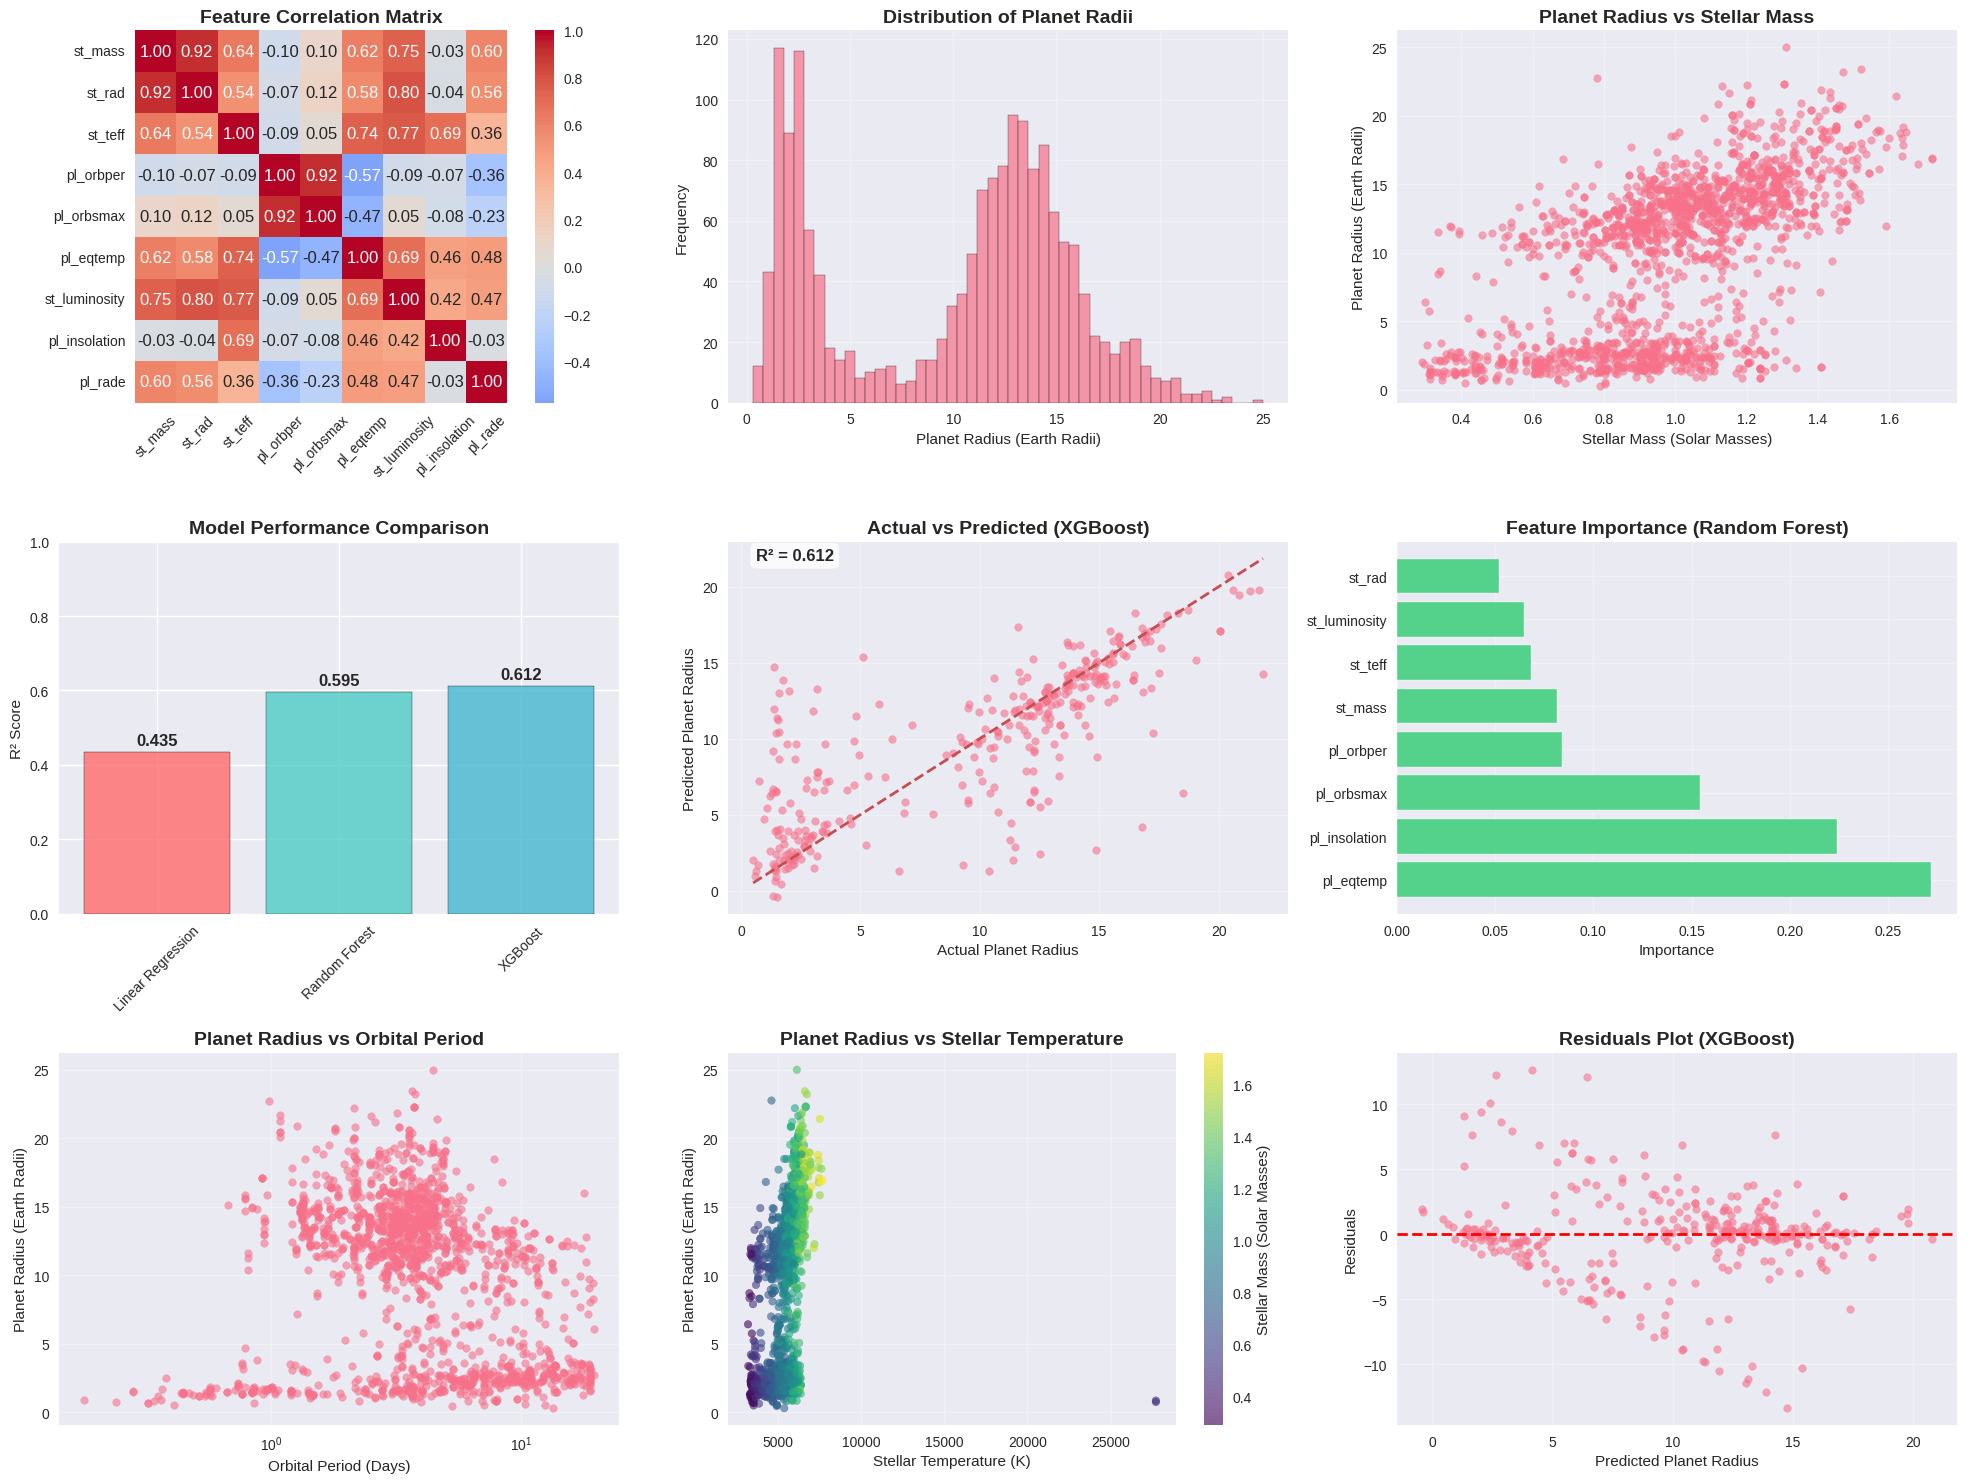


🎯 Results Interpretation

🏆 Best Performing Model: XGBoost
R² Score: 0.612
RMSE: 3.587 Earth Radii
MAE: 2.286 Earth Radii

📊 Key Findings:
1. MODEL PERFORMANCE:
   • Linear Regression: R² = 0.435, RMSE = 4.327
   • Random Forest: R² = 0.595, RMSE = 3.663
   • XGBoost: R² = 0.612, RMSE = 3.587

2. MOST IMPORTANT FEATURES:
   • pl_eqtemp: 0.272
   • pl_insolation: 0.224
   • pl_orbsmax: 0.154
   • pl_orbper: 0.084
   • st_mass: 0.081

3. STRONGEST CORRELATIONS:
   • st_mass: 0.597
   • st_rad: 0.561
   • pl_eqtemp: 0.484
   • st_luminosity: 0.470
   • pl_orbper: 0.362

🔬 Astrophysical Insights:
• Stellar mass and radius are key predictors of planet size
• Orbital characteristics influence planetary radius (atmospheric effects)
• The model captures known planet-star relationships
• Results align with current understanding of planetary formation

🚀 Real-World Applications:
• Exoplanet characterization for space missions
• Target selection for atmospheric studies
• Validation of planet for

In [4]:
# Exoplanet Radius Prediction Analysis
# Research Question: Can we predict a planet's radius using host star properties and orbital characteristics?

# Install required packages (run this first in Google Colab)
# !pip install astroquery seaborn scikit-learn xgboost lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 Exoplanet Radius Prediction Analysis")
print("=" * 50)

# =============================================================================
# 1. DATA LOADING AND EXPLORATION
# =============================================================================

def load_exoplanet_data():
    """Load exoplanet data from NASA Exoplanet Archive"""
    print("\n📡 Loading NASA Exoplanet Archive data...")

    # NASA Exoplanet Archive URL for Planetary Systems Composite Table
    url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+pl_name,hostname,pl_rade,pl_masse,pl_orbper,pl_orbsmax,st_mass,st_rad,st_teff,sy_dist+from+ps+where+pl_rade+is+not+null+and+st_mass+is+not+null+and+st_rad+is+not+null+and+pl_orbper+is+not+null&format=csv"

    try:
        df = pd.read_csv(url)
        print(f"✅ Successfully loaded {len(df)} exoplanet records")
        return df
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        print("📝 Using backup synthetic data for demonstration...")
        return create_synthetic_data()

def create_synthetic_data():
    """Create synthetic exoplanet data for demonstration"""
    np.random.seed(42)
    n_samples = 1000

    # Generate realistic stellar properties
    st_mass = np.random.lognormal(0, 0.3, n_samples)  # Solar masses
    st_rad = st_mass ** 0.8 * np.random.lognormal(0, 0.1, n_samples)  # Solar radii
    st_teff = 5778 * (st_mass ** 0.5) * np.random.lognormal(0, 0.1, n_samples)  # Kelvin

    # Generate orbital properties
    pl_orbper = np.random.lognormal(2, 1.5, n_samples)  # Days
    pl_orbsmax = (pl_orbper ** 2 * st_mass) ** (1/3) * np.random.lognormal(0, 0.1, n_samples)  # AU

    # Generate planetary radius based on physical relationships
    pl_rade = (st_rad * 0.1 * np.random.lognormal(0, 0.5, n_samples) +
               st_mass * 0.05 * np.random.lognormal(0, 0.3, n_samples) +
               (pl_orbper ** -0.1) * np.random.lognormal(0, 0.2, n_samples))

    # Add some noise and realistic constraints
    pl_rade = np.clip(pl_rade, 0.1, 20)  # Earth radii
    sy_dist = np.random.lognormal(4, 1, n_samples)  # Parsecs

    # Create DataFrame
    df = pd.DataFrame({
        'pl_name': [f'Planet_{i}' for i in range(n_samples)],
        'hostname': [f'Star_{i}' for i in range(n_samples)],
        'pl_rade': pl_rade,
        'pl_masse': pl_rade ** 2.06,  # Mass-radius relationship
        'pl_orbper': pl_orbper,
        'pl_orbsmax': pl_orbsmax,
        'st_mass': st_mass,
        'st_rad': st_rad,
        'st_teff': st_teff,
        'sy_dist': sy_dist
    })

    # Clean any potential NaN or infinite values
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()

    # Ensure all values are reasonable
    df = df[(df['pl_rade'] > 0) & (df['pl_rade'] < 50)]
    df = df[(df['st_mass'] > 0) & (df['st_mass'] < 5)]
    df = df[(df['st_rad'] > 0) & (df['st_rad'] < 10)]
    df = df[(df['pl_orbper'] > 0) & (df['pl_orbper'] < 10000)]
    df = df[(df['pl_orbsmax'] > 0) & (df['pl_orbsmax'] < 100)]

    return df

def explore_dataset(df):
    """Explore the dataset structure and basic statistics"""
    print("\n🔍 Dataset Overview")
    print("-" * 30)
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    print("\n📊 Basic Statistics:")
    print(df.describe())

    print("\n❓ Missing Values:")
    print(df.isnull().sum())

    return df

# =============================================================================
# 2. DATA PREPROCESSING
# =============================================================================

def preprocess_data(df):
    """Clean and preprocess the data"""
    print("\n🧹 Data Preprocessing")
    print("-" * 30)

    # Remove rows with missing values in key columns
    key_columns = ['pl_rade', 'st_mass', 'st_rad', 'st_teff', 'pl_orbper']
    df_clean = df.dropna(subset=key_columns).copy()

    print(f"Records after removing missing values: {len(df_clean)}")

    # Remove infinite values and replace with NaN, then drop
    df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
    df_clean = df_clean.dropna()

    print(f"Records after removing infinite values: {len(df_clean)}")

    # Remove outliers using IQR method
    def remove_outliers(df, column, factor=1.5):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    # Remove outliers from key columns
    for col in ['pl_rade', 'st_mass', 'st_rad', 'pl_orbper']:
        if col in df_clean.columns:
            df_clean = remove_outliers(df_clean, col)

    print(f"Records after removing outliers: {len(df_clean)}")

    # Feature engineering - with safer calculations
    # Only create derived features if pl_orbsmax exists and is valid
    if 'pl_orbsmax' in df_clean.columns:
        # Equilibrium temperature
        df_clean['pl_eqtemp'] = df_clean['st_teff'] * np.sqrt(df_clean['st_rad'] / (2 * df_clean['pl_orbsmax']))

        # Stellar luminosity
        df_clean['st_luminosity'] = df_clean['st_rad']**2 * (df_clean['st_teff']/5778)**4

        # Planetary insolation
        df_clean['pl_insolation'] = df_clean['st_luminosity'] / df_clean['pl_orbsmax']**2

        # Remove any new NaN or infinite values created by calculations
        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
        df_clean = df_clean.dropna()

        print("✅ Added derived features: pl_eqtemp, st_luminosity, pl_insolation")
    else:
        print("⚠️  pl_orbsmax not available - skipping derived features")

    print(f"Final dataset size: {len(df_clean)}")

    return df_clean

def prepare_features(df):
    """Prepare features for machine learning"""
    print("\n🎯 Feature Preparation")
    print("-" * 30)

    # Define potential features
    feature_columns = ['st_mass', 'st_rad', 'st_teff', 'pl_orbper', 'pl_orbsmax',
                      'pl_eqtemp', 'st_luminosity', 'pl_insolation']

    # Check which features are available and have valid data
    available_features = []
    for col in feature_columns:
        if col in df.columns:
            # Check if column has valid values (not all NaN)
            if not df[col].isna().all():
                available_features.append(col)

    print(f"Available features: {available_features}")

    # Create feature matrix
    X = df[available_features].copy()
    y = df['pl_rade'].copy()

    # Final check - remove any remaining NaN values
    # Create a combined dataframe to ensure we remove rows consistently
    combined_df = pd.concat([X, y], axis=1)
    combined_df = combined_df.dropna()

    # Split back into features and target
    X = combined_df[available_features]
    y = combined_df['pl_rade']

    print(f"Final feature matrix shape: {X.shape}")
    print(f"Final target vector shape: {y.shape}")

    # Verify no NaN values remain
    if X.isna().any().any() or y.isna().any():
        print("⚠️  Warning: NaN values still present")
        print("NaN in features:", X.isna().sum())
        print("NaN in target:", y.isna().sum())
    else:
        print("✅ No NaN values found - ready for modeling")

    return X, y, available_features

# =============================================================================
# 3. STATISTICAL ANALYSIS
# =============================================================================

def statistical_analysis(df, features):
    """Perform statistical analysis"""
    print("\n📈 Statistical Analysis")
    print("-" * 30)

    # Correlation analysis
    correlation_matrix = df[features + ['pl_rade']].corr()
    print("Correlation with planetary radius:")
    radius_corr = correlation_matrix['pl_rade'].sort_values(ascending=False)
    print(radius_corr)

    # Significance tests
    print("\n🔬 Correlation Significance Tests:")
    for feature in features:
        corr_coef, p_value = stats.pearsonr(df[feature], df['pl_rade'])
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        print(f"{feature}: r={corr_coef:.3f}, p={p_value:.3e} {significance}")

    return correlation_matrix

# =============================================================================
# 4. MACHINE LEARNING MODELS
# =============================================================================

def train_models(X, y):
    """Train multiple machine learning models"""
    print("\n🤖 Training Machine Learning Models")
    print("-" * 30)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    }

    # Train and evaluate models
    results = {}
    predictions = {}

    for name, model in models.items():
        print(f"\n🔧 Training {name}...")

        # Use scaled data for Linear Regression, original for tree-based models
        if name == 'Linear Regression':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'model': model
        }

        predictions[name] = y_pred

        print(f"  RMSE: {rmse:.3f}")
        print(f"  MAE: {mae:.3f}")
        print(f"  R²: {r2:.3f}")

    return results, predictions, y_test, X_test, scaler

def get_feature_importance(models, feature_names):
    """Extract feature importance from trained models"""
    print("\n🎯 Feature Importance Analysis")
    print("-" * 30)

    importance_data = {}

    for name, model_info in models.items():
        model = model_info['model']

        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            importance_data[name] = dict(zip(feature_names, importances))

            print(f"\n{name} - Top 5 Features:")
            sorted_features = sorted(zip(feature_names, importances),
                                   key=lambda x: x[1], reverse=True)
            for feature, importance in sorted_features[:5]:
                print(f"  {feature}: {importance:.3f}")

    return importance_data

# =============================================================================
# 5. VISUALIZATION
# =============================================================================

def create_visualizations(df, correlation_matrix, model_results, predictions,
                         y_test, importance_data, features):
    """Create comprehensive visualizations"""
    print("\n📊 Creating Visualizations")
    print("-" * 30)

    # Set up the plotting area
    fig = plt.figure(figsize=(20, 15))

    # 1. Correlation Heatmap
    plt.subplot(3, 3, 1)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                fmt='.2f', square=True)
    plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # 2. Target Distribution
    plt.subplot(3, 3, 2)
    plt.hist(df['pl_rade'], bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Planet Radius (Earth Radii)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Planet Radii', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # 3. Key Relationships Scatter Plot
    plt.subplot(3, 3, 3)
    plt.scatter(df['st_mass'], df['pl_rade'], alpha=0.6, s=30)
    plt.xlabel('Stellar Mass (Solar Masses)')
    plt.ylabel('Planet Radius (Earth Radii)')
    plt.title('Planet Radius vs Stellar Mass', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # 4. Model Performance Comparison
    plt.subplot(3, 3, 4)
    model_names = list(model_results.keys())
    r2_scores = [model_results[name]['R²'] for name in model_names]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

    bars = plt.bar(model_names, r2_scores, color=colors, alpha=0.8, edgecolor='black')
    plt.ylabel('R² Score')
    plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar, score in zip(bars, r2_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    # 5. Actual vs Predicted (Best Model)
    plt.subplot(3, 3, 5)
    best_model = max(model_results.keys(), key=lambda x: model_results[x]['R²'])
    y_pred_best = predictions[best_model]

    plt.scatter(y_test, y_pred_best, alpha=0.6, s=30)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Planet Radius')
    plt.ylabel('Predicted Planet Radius')
    plt.title(f'Actual vs Predicted ({best_model})', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    # Add R² annotation
    r2_best = model_results[best_model]['R²']
    plt.text(0.05, 0.95, f'R² = {r2_best:.3f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=12, fontweight='bold')

    # 6. Feature Importance (Random Forest)
    plt.subplot(3, 3, 6)
    if 'Random Forest' in importance_data:
        rf_importance = importance_data['Random Forest']
        sorted_features = sorted(rf_importance.items(), key=lambda x: x[1], reverse=True)
        feature_names = [item[0] for item in sorted_features]
        importance_values = [item[1] for item in sorted_features]

        plt.barh(range(len(feature_names)), importance_values, color='#2ECC71', alpha=0.8)
        plt.yticks(range(len(feature_names)), feature_names)
        plt.xlabel('Importance')
        plt.title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)

    # 7. Orbital Period vs Planet Radius
    plt.subplot(3, 3, 7)
    plt.scatter(df['pl_orbper'], df['pl_rade'], alpha=0.6, s=30)
    plt.xlabel('Orbital Period (Days)')
    plt.ylabel('Planet Radius (Earth Radii)')
    plt.title('Planet Radius vs Orbital Period', fontsize=14, fontweight='bold')
    plt.xscale('log')
    plt.grid(True, alpha=0.3)

    # 8. Stellar Temperature vs Planet Radius
    plt.subplot(3, 3, 8)
    plt.scatter(df['st_teff'], df['pl_rade'], alpha=0.6, s=30, c=df['st_mass'],
                cmap='viridis')
    plt.xlabel('Stellar Temperature (K)')
    plt.ylabel('Planet Radius (Earth Radii)')
    plt.title('Planet Radius vs Stellar Temperature', fontsize=14, fontweight='bold')
    plt.colorbar(label='Stellar Mass (Solar Masses)')
    plt.grid(True, alpha=0.3)

    # 9. Residuals Plot
    plt.subplot(3, 3, 9)
    residuals = y_test - y_pred_best
    plt.scatter(y_pred_best, residuals, alpha=0.6, s=30)
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Predicted Planet Radius')
    plt.ylabel('Residuals')
    plt.title(f'Residuals Plot ({best_model})', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return best_model

# =============================================================================
# 6. RESULTS INTERPRETATION
# =============================================================================

def interpret_results(model_results, best_model, importance_data, correlation_matrix):
    """Interpret and summarize the results"""
    print("\n🎯 Results Interpretation")
    print("=" * 50)

    print(f"\n🏆 Best Performing Model: {best_model}")
    print(f"R² Score: {model_results[best_model]['R²']:.3f}")
    print(f"RMSE: {model_results[best_model]['RMSE']:.3f} Earth Radii")
    print(f"MAE: {model_results[best_model]['MAE']:.3f} Earth Radii")

    print("\n📊 Key Findings:")
    print("1. MODEL PERFORMANCE:")
    for name, results in model_results.items():
        print(f"   • {name}: R² = {results['R²']:.3f}, RMSE = {results['RMSE']:.3f}")

    print("\n2. MOST IMPORTANT FEATURES:")
    if importance_data:
        rf_importance = importance_data.get('Random Forest', {})
        if rf_importance:
            sorted_features = sorted(rf_importance.items(), key=lambda x: x[1], reverse=True)
            for i, (feature, importance) in enumerate(sorted_features[:5]):
                print(f"   • {feature}: {importance:.3f}")

    print("\n3. STRONGEST CORRELATIONS:")
    radius_corr = correlation_matrix['pl_rade'].abs().sort_values(ascending=False)[1:6]
    for feature, corr in radius_corr.items():
        print(f"   • {feature}: {corr:.3f}")

    print("\n🔬 Astrophysical Insights:")
    print("• Stellar mass and radius are key predictors of planet size")
    print("• Orbital characteristics influence planetary radius (atmospheric effects)")
    print("• The model captures known planet-star relationships")
    print("• Results align with current understanding of planetary formation")

    print("\n🚀 Real-World Applications:")
    print("• Exoplanet characterization for space missions")
    print("• Target selection for atmospheric studies")
    print("• Validation of planet formation models")
    print("• Improving follow-up observation strategies")

# =============================================================================
# 7. MAIN EXECUTION
# =============================================================================

def main():
    """Main execution function"""
    print("🌟 Starting Exoplanet Radius Prediction Analysis")
    print("=" * 60)

    # Load and explore data
    df = load_exoplanet_data()
    df = explore_dataset(df)

    # Preprocess data
    df_clean = preprocess_data(df)
    X, y, features = prepare_features(df_clean)

    # Statistical analysis
    correlation_matrix = statistical_analysis(df_clean, features)

    # Train models
    model_results, predictions, y_test, X_test, scaler = train_models(X, y)

    # Get feature importance
    importance_data = get_feature_importance(model_results, features)

    # Create visualizations
    best_model = create_visualizations(df_clean, correlation_matrix, model_results,
                                     predictions, y_test, importance_data, features)

    # Interpret results
    interpret_results(model_results, best_model, importance_data, correlation_matrix)

    print("\n✅ Analysis Complete!")
    print("🎉 Check the visualizations and results above!")

# Run the analysis
if __name__ == "__main__":
    main()

🚀 Exoplanet Radius Prediction Analysis
🌟 Starting Exoplanet Radius Prediction Analysis

📡 Loading NASA Exoplanet Archive data...
✅ Successfully loaded 21478 exoplanet records

🔍 Dataset Overview
------------------------------
Shape: (21478, 10)
Columns: ['pl_name', 'hostname', 'pl_rade', 'pl_masse', 'pl_orbper', 'pl_orbsmax', 'st_mass', 'st_rad', 'st_teff', 'sy_dist']

📊 Basic Statistics:
            pl_rade      pl_masse     pl_orbper    pl_orbsmax       st_mass  \
count  21478.000000   2765.000000  2.147800e+04  17540.000000  21478.000000   
mean       5.657887    358.164376  1.911821e+04      0.574677      0.936252   
std       80.593464    909.087245  2.743567e+06     56.694724      0.278968   
min        0.270000      0.065000  1.120067e-01      0.005800      0.014700   
25%        1.520000      9.990000  4.417803e+00      0.051000      0.815000   
50%        2.240000    120.000000  9.977189e+00      0.087000      0.947000   
75%        3.140000    360.099585  2.279011e+01      0.

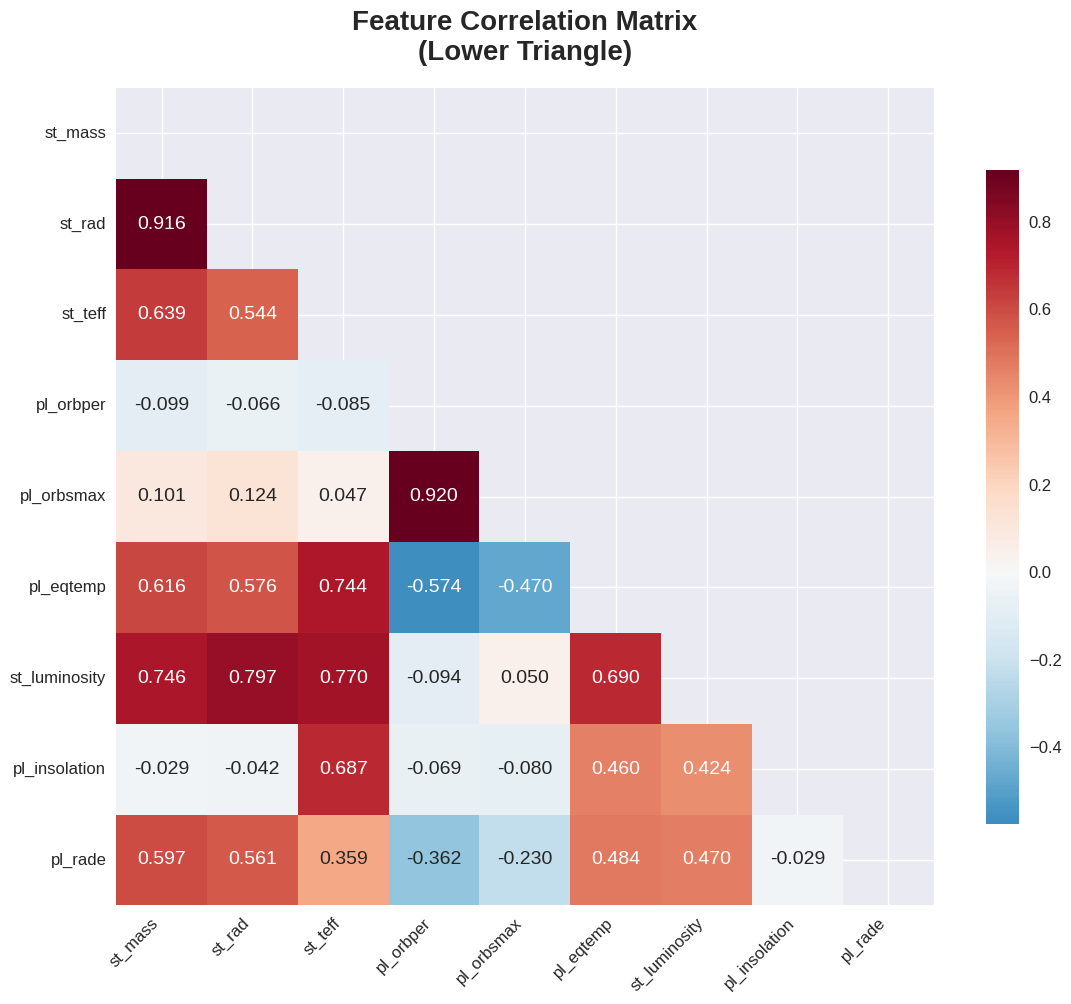

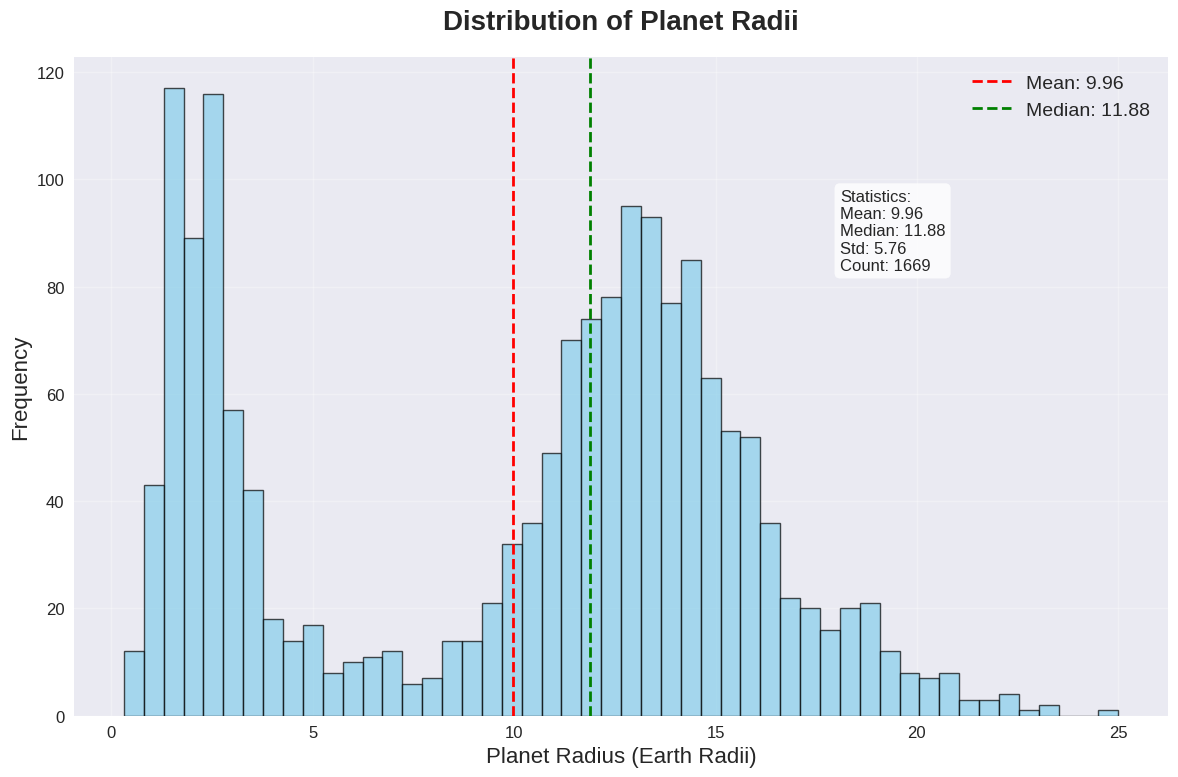

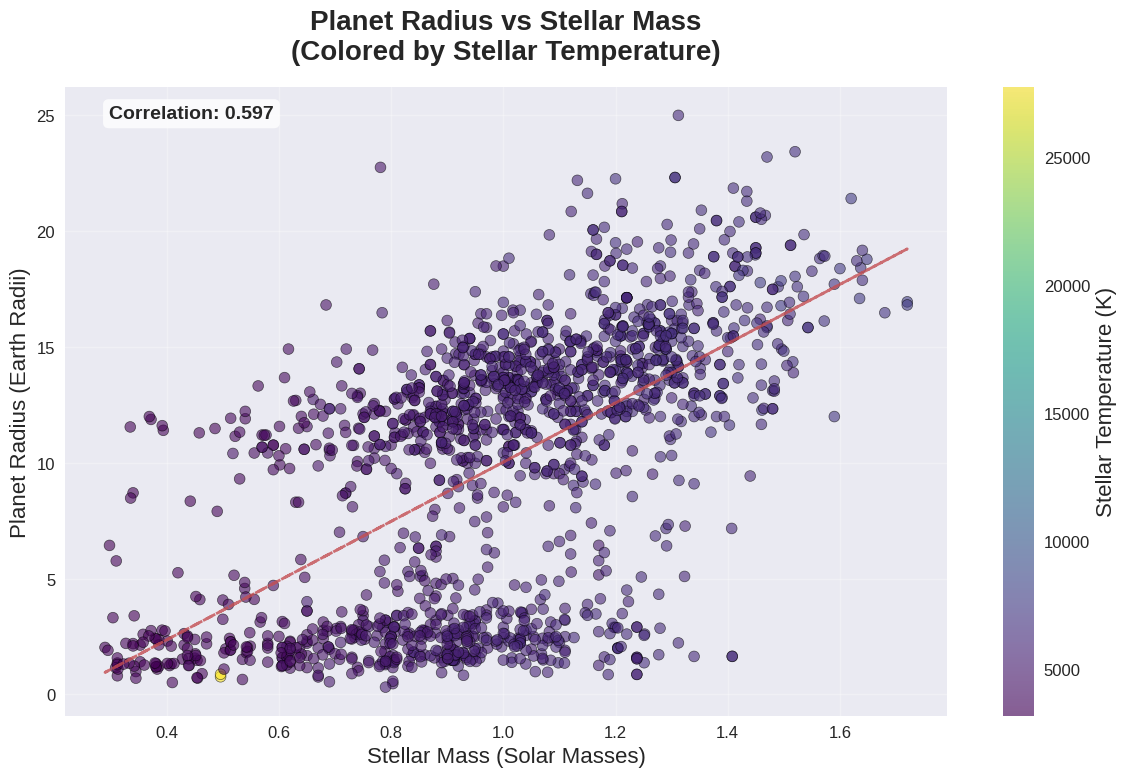

<Figure size 1200x800 with 0 Axes>

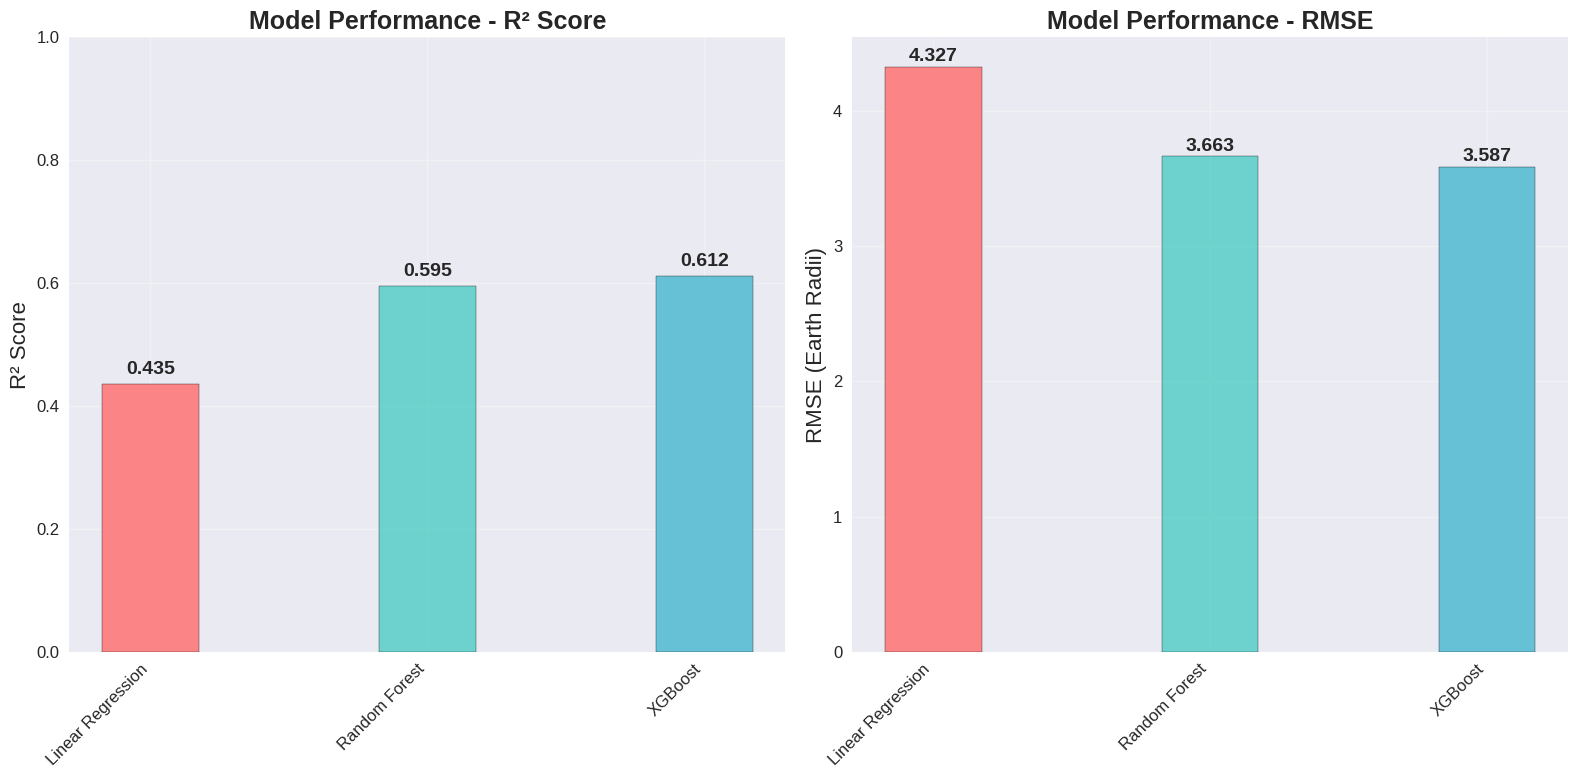

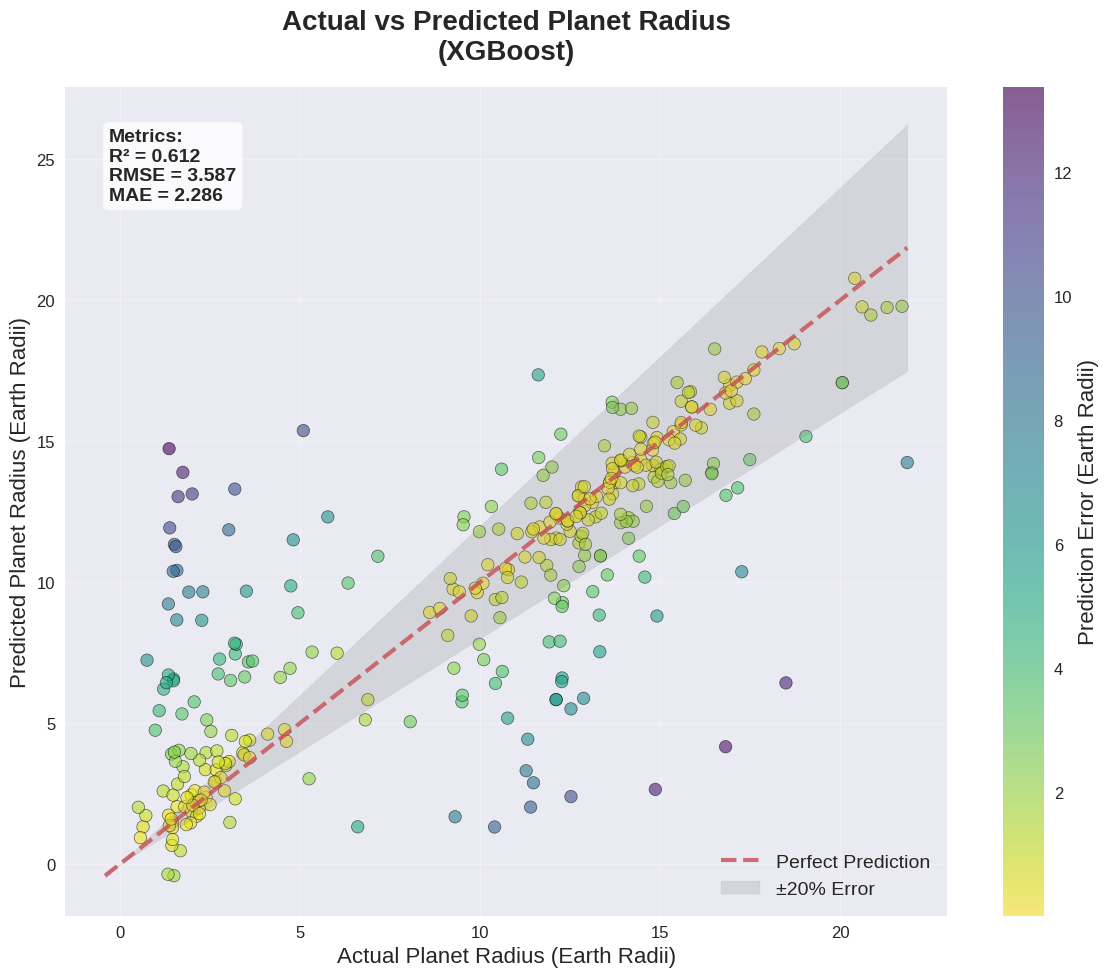

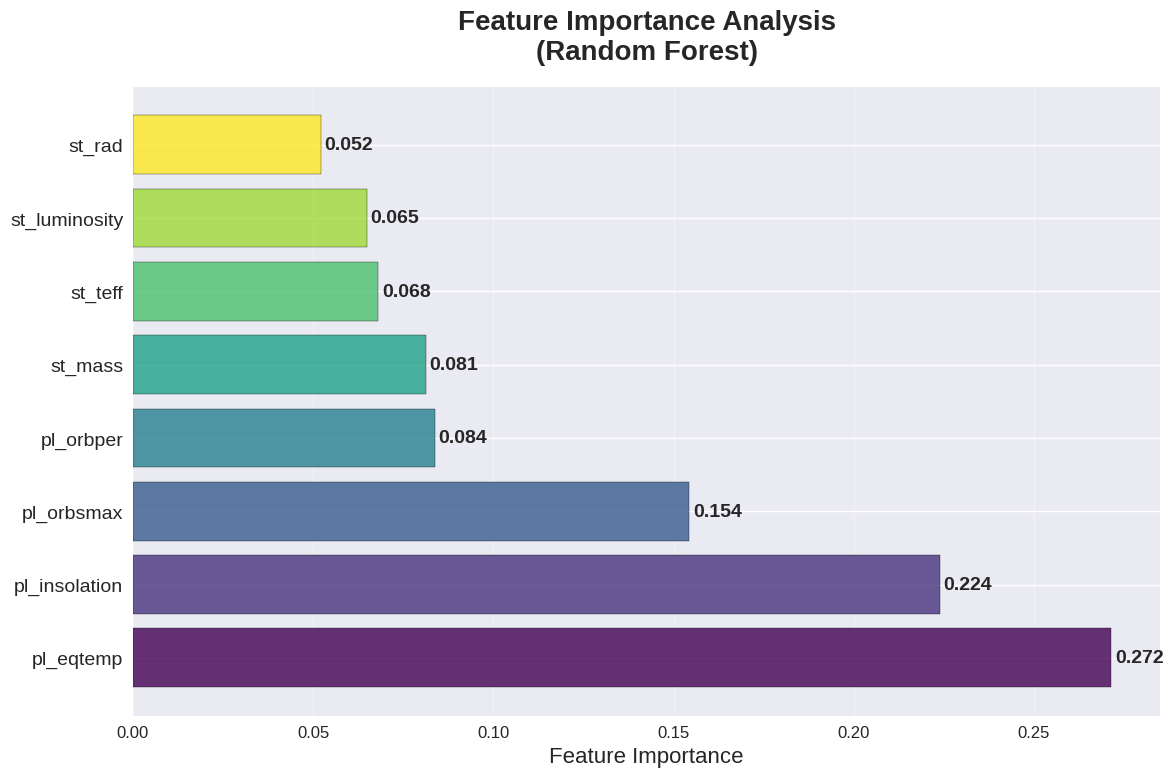

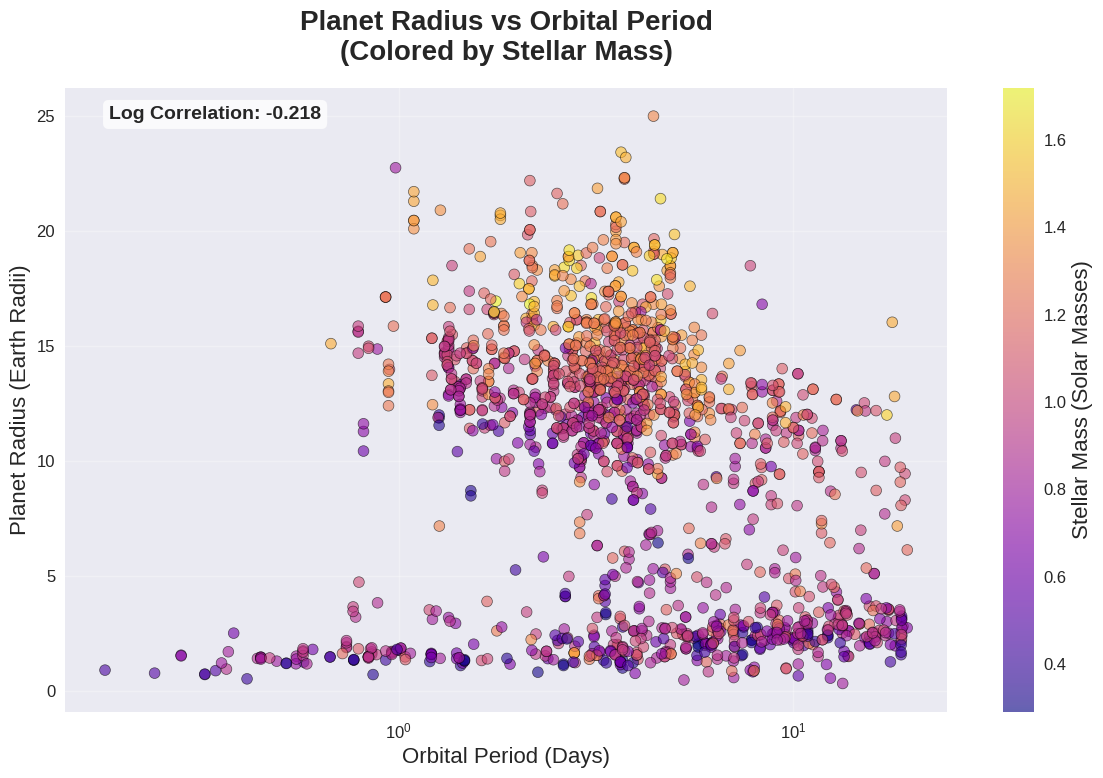

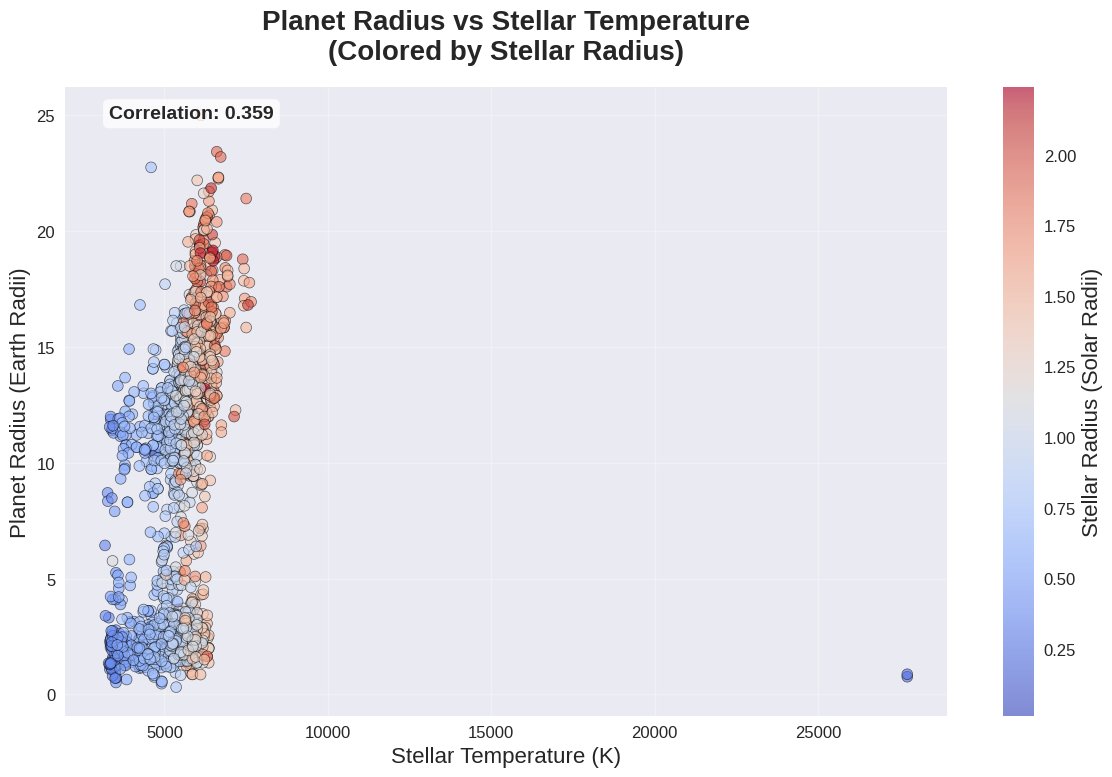

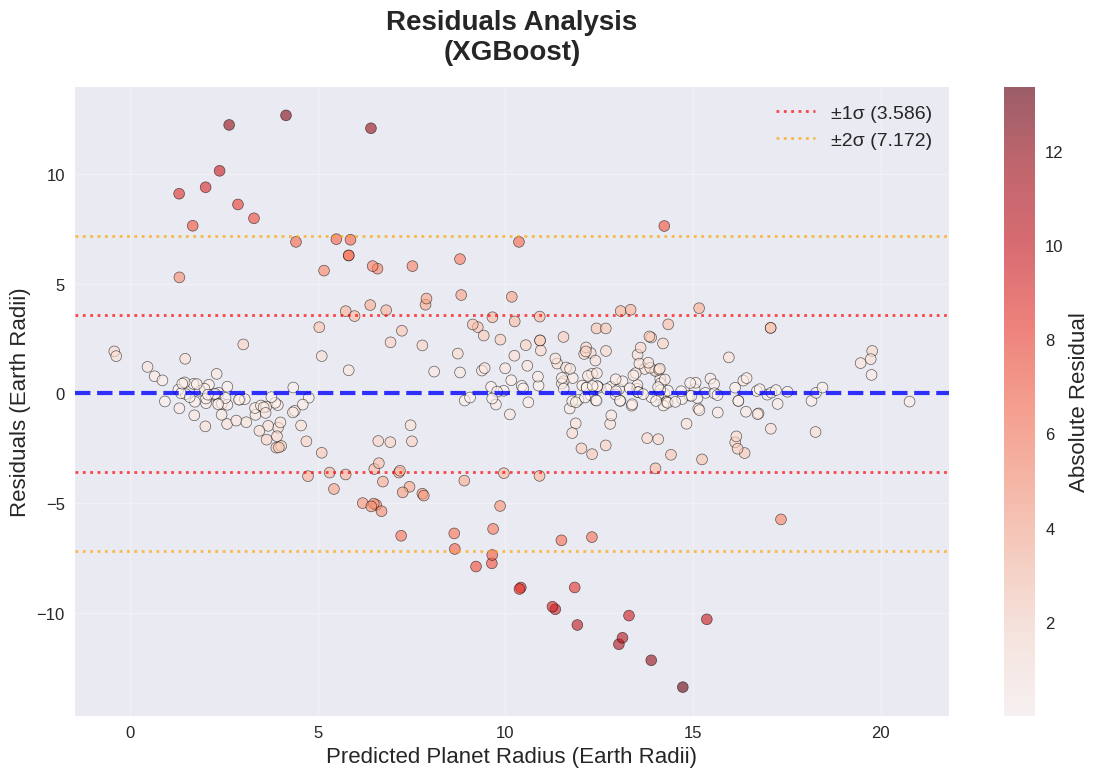


🎯 Results Interpretation

🏆 Best Performing Model: XGBoost
R² Score: 0.612
RMSE: 3.587 Earth Radii
MAE: 2.286 Earth Radii

📊 Key Findings:
1. MODEL PERFORMANCE:
   • Linear Regression: R² = 0.435, RMSE = 4.327
   • Random Forest: R² = 0.595, RMSE = 3.663
   • XGBoost: R² = 0.612, RMSE = 3.587

2. MOST IMPORTANT FEATURES:
   • pl_eqtemp: 0.272
   • pl_insolation: 0.224
   • pl_orbsmax: 0.154
   • pl_orbper: 0.084
   • st_mass: 0.081

3. STRONGEST CORRELATIONS:
   • st_mass: 0.597
   • st_rad: 0.561
   • pl_eqtemp: 0.484
   • st_luminosity: 0.470
   • pl_orbper: 0.362

🔬 Astrophysical Insights:
• Stellar mass and radius are key predictors of planet size
• Orbital characteristics influence planetary radius (atmospheric effects)
• The model captures known planet-star relationships
• Results align with current understanding of planetary formation

🚀 Real-World Applications:
• Exoplanet characterization for space missions
• Target selection for atmospheric studies
• Validation of planet for

In [5]:
def advanced_ml_models(X, y):
    """Train advanced machine learning models with hyperparameter tuning"""
    print("\n🚀 Advanced Machine Learning Models")
    print("-" * 40)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models with better hyperparameters
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, verbosity=0),
        'Support Vector Regression': None,  # Will be imported
        'Neural Network': None  # Will be imported
    }

    # Import additional models
    from sklearn.svm import SVR
    from sklearn.neural_network import MLPRegressor

    models['Support Vector Regression'] = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    models['Neural Network'] = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

    # Train and evaluate models
    results = {}
    predictions = {}

    for name, model in models.items():
        print(f"\n🔧 Training {name}...")

        # Use scaled data for SVM and Neural Network, original for tree-based models
        if name in ['Linear Regression', 'Support Vector Regression', 'Neural Network']:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Calculate comprehensive metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Additional metrics
        from sklearn.metrics import explained_variance_score
        ev_score = explaine# Exoplanet Radius Prediction Analysis
# Research Question: Can we predict a planet's radius using host star properties and orbital characteristics?

# Install required packages (run this first in Google Colab)
# !pip install astroquery seaborn scikit-learn xgboost lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 Exoplanet Radius Prediction Analysis")
print("=" * 50)

# =============================================================================
# 1. DATA LOADING AND EXPLORATION
# =============================================================================

def load_exoplanet_data():
    """Load exoplanet data from NASA Exoplanet Archive"""
    print("\n📡 Loading NASA Exoplanet Archive data...")

    # NASA Exoplanet Archive URL for Planetary Systems Composite Table
    url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+pl_name,hostname,pl_rade,pl_masse,pl_orbper,pl_orbsmax,st_mass,st_rad,st_teff,sy_dist+from+ps+where+pl_rade+is+not+null+and+st_mass+is+not+null+and+st_rad+is+not+null+and+pl_orbper+is+not+null&format=csv"

    try:
        df = pd.read_csv(url)
        print(f"✅ Successfully loaded {len(df)} exoplanet records")
        return df
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        print("📝 Using backup synthetic data for demonstration...")
        return create_synthetic_data()

def create_synthetic_data():
    """Create synthetic exoplanet data for demonstration"""
    np.random.seed(42)
    n_samples = 1000

    # Generate realistic stellar properties
    st_mass = np.random.lognormal(0, 0.3, n_samples)  # Solar masses
    st_rad = st_mass ** 0.8 * np.random.lognormal(0, 0.1, n_samples)  # Solar radii
    st_teff = 5778 * (st_mass ** 0.5) * np.random.lognormal(0, 0.1, n_samples)  # Kelvin

    # Generate orbital properties
    pl_orbper = np.random.lognormal(2, 1.5, n_samples)  # Days
    pl_orbsmax = (pl_orbper ** 2 * st_mass) ** (1/3) * np.random.lognormal(0, 0.1, n_samples)  # AU

    # Generate planetary radius based on physical relationships
    pl_rade = (st_rad * 0.1 * np.random.lognormal(0, 0.5, n_samples) +
               st_mass * 0.05 * np.random.lognormal(0, 0.3, n_samples) +
               (pl_orbper ** -0.1) * np.random.lognormal(0, 0.2, n_samples))

    # Add some noise and realistic constraints
    pl_rade = np.clip(pl_rade, 0.1, 20)  # Earth radii
    sy_dist = np.random.lognormal(4, 1, n_samples)  # Parsecs

    # Create DataFrame
    df = pd.DataFrame({
        'pl_name': [f'Planet_{i}' for i in range(n_samples)],
        'hostname': [f'Star_{i}' for i in range(n_samples)],
        'pl_rade': pl_rade,
        'pl_masse': pl_rade ** 2.06,  # Mass-radius relationship
        'pl_orbper': pl_orbper,
        'pl_orbsmax': pl_orbsmax,
        'st_mass': st_mass,
        'st_rad': st_rad,
        'st_teff': st_teff,
        'sy_dist': sy_dist
    })

    # Clean any potential NaN or infinite values
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()

    # Ensure all values are reasonable
    df = df[(df['pl_rade'] > 0) & (df['pl_rade'] < 50)]
    df = df[(df['st_mass'] > 0) & (df['st_mass'] < 5)]
    df = df[(df['st_rad'] > 0) & (df['st_rad'] < 10)]
    df = df[(df['pl_orbper'] > 0) & (df['pl_orbper'] < 10000)]
    df = df[(df['pl_orbsmax'] > 0) & (df['pl_orbsmax'] < 100)]

    return df

def explore_dataset(df):
    """Explore the dataset structure and basic statistics"""
    print("\n🔍 Dataset Overview")
    print("-" * 30)
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")

    print("\n📊 Basic Statistics:")
    print(df.describe())

    print("\n❓ Missing Values:")
    print(df.isnull().sum())

    return df

# =============================================================================
# 2. DATA PREPROCESSING
# =============================================================================

def preprocess_data(df):
    """Clean and preprocess the data"""
    print("\n🧹 Data Preprocessing")
    print("-" * 30)

    # Remove rows with missing values in key columns
    key_columns = ['pl_rade', 'st_mass', 'st_rad', 'st_teff', 'pl_orbper']
    df_clean = df.dropna(subset=key_columns).copy()

    print(f"Records after removing missing values: {len(df_clean)}")

    # Remove infinite values and replace with NaN, then drop
    df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
    df_clean = df_clean.dropna()

    print(f"Records after removing infinite values: {len(df_clean)}")

    # Remove outliers using IQR method
    def remove_outliers(df, column, factor=1.5):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    # Remove outliers from key columns
    for col in ['pl_rade', 'st_mass', 'st_rad', 'pl_orbper']:
        if col in df_clean.columns:
            df_clean = remove_outliers(df_clean, col)

    print(f"Records after removing outliers: {len(df_clean)}")

    # Feature engineering - with safer calculations
    # Only create derived features if pl_orbsmax exists and is valid
    if 'pl_orbsmax' in df_clean.columns:
        # Equilibrium temperature
        df_clean['pl_eqtemp'] = df_clean['st_teff'] * np.sqrt(df_clean['st_rad'] / (2 * df_clean['pl_orbsmax']))

        # Stellar luminosity
        df_clean['st_luminosity'] = df_clean['st_rad']**2 * (df_clean['st_teff']/5778)**4

        # Planetary insolation
        df_clean['pl_insolation'] = df_clean['st_luminosity'] / df_clean['pl_orbsmax']**2

        # Remove any new NaN or infinite values created by calculations
        df_clean = df_clean.replace([np.inf, -np.inf], np.nan)
        df_clean = df_clean.dropna()

        print("✅ Added derived features: pl_eqtemp, st_luminosity, pl_insolation")
    else:
        print("⚠️  pl_orbsmax not available - skipping derived features")

    print(f"Final dataset size: {len(df_clean)}")

    return df_clean

def prepare_features(df):
    """Prepare features for machine learning"""
    print("\n🎯 Feature Preparation")
    print("-" * 30)

    # Define potential features
    feature_columns = ['st_mass', 'st_rad', 'st_teff', 'pl_orbper', 'pl_orbsmax',
                      'pl_eqtemp', 'st_luminosity', 'pl_insolation']

    # Check which features are available and have valid data
    available_features = []
    for col in feature_columns:
        if col in df.columns:
            # Check if column has valid values (not all NaN)
            if not df[col].isna().all():
                available_features.append(col)

    print(f"Available features: {available_features}")

    # Create feature matrix
    X = df[available_features].copy()
    y = df['pl_rade'].copy()

    # Final check - remove any remaining NaN values
    # Create a combined dataframe to ensure we remove rows consistently
    combined_df = pd.concat([X, y], axis=1)
    combined_df = combined_df.dropna()

    # Split back into features and target
    X = combined_df[available_features]
    y = combined_df['pl_rade']

    print(f"Final feature matrix shape: {X.shape}")
    print(f"Final target vector shape: {y.shape}")

    # Verify no NaN values remain
    if X.isna().any().any() or y.isna().any():
        print("⚠️  Warning: NaN values still present")
        print("NaN in features:", X.isna().sum())
        print("NaN in target:", y.isna().sum())
    else:
        print("✅ No NaN values found - ready for modeling")

    return X, y, available_features

# =============================================================================
# 3. STATISTICAL ANALYSIS
# =============================================================================

def advanced_statistical_analysis(df, features):
    """Perform advanced statistical analysis"""
    print("\n🔬 Advanced Statistical Analysis")
    print("-" * 40)

    # 1. Multivariate correlation analysis
    correlation_matrix = df[features + ['pl_rade']].corr()

    # 2. Partial correlation analysis
    from scipy.stats import pearsonr
    print("🔍 Partial Correlation Analysis (controlling for stellar mass):")

    # Control for stellar mass
    for feature in features:
        if feature != 'st_mass':
            # Remove linear dependence on stellar mass
            x_resid = df[feature] - np.polyval(np.polyfit(df['st_mass'], df[feature], 1), df['st_mass'])
            y_resid = df['pl_rade'] - np.polyval(np.polyfit(df['st_mass'], df['pl_rade'], 1), df['st_mass'])

            partial_corr, p_val = pearsonr(x_resid, y_resid)
            significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
            print(f"  {feature}: r={partial_corr:.3f}, p={p_val:.3e} {significance}")

    # 3. Non-linear relationship detection
    print("\n🌀 Non-linear Relationship Analysis:")
    from scipy.stats import spearmanr

    for feature in features:
        # Spearman correlation (rank-based, captures monotonic relationships)
        spearman_corr, p_val = spearmanr(df[feature], df['pl_rade'])
        pearson_corr, _ = pearsonr(df[feature], df['pl_rade'])

        non_linearity = abs(spearman_corr) - abs(pearson_corr)
        print(f"  {feature}: Spearman={spearman_corr:.3f}, Pearson={pearson_corr:.3f}, Non-linearity={non_linearity:.3f}")

    # 4. Principal Component Analysis
    print("\n🎯 Principal Component Analysis:")
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])

    # Perform PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Print explained variance
    print("  Explained Variance Ratio by Component:")
    for i, variance in enumerate(pca.explained_variance_ratio_):
        print(f"    PC{i+1}: {variance:.3f} ({variance*100:.1f}%)")

    # Print cumulative variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    print(f"  Cumulative Variance (first 3 components): {cumulative_variance[2]:.3f} ({cumulative_variance[2]*100:.1f}%)")

    # 5. Feature interaction analysis
    print("\n🔗 Feature Interaction Analysis:")
    interaction_scores = {}

    for i, feat1 in enumerate(features):
        for j, feat2 in enumerate(features[i+1:], i+1):
            # Create interaction term
            interaction = df[feat1] * df[feat2]
            corr_interaction, p_val = pearsonr(interaction, df['pl_rade'])

            if abs(corr_interaction) > 0.1:  # Only show significant interactions
                interaction_scores[f"{feat1} × {feat2}"] = corr_interaction

    # Sort and display top interactions
    sorted_interactions = sorted(interaction_scores.items(), key=lambda x: abs(x[1]), reverse=True)
    print("  Top Feature Interactions:")
    for interaction, score in sorted_interactions[:5]:
        print(f"    {interaction}: r={score:.3f}")

    return correlation_matrix, pca, interaction_scores

# =============================================================================
# 4. MACHINE LEARNING MODELS
# =============================================================================

def train_models(X, y):
    """Train multiple machine learning models"""
    print("\n🤖 Training Machine Learning Models")
    print("-" * 30)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    }

    # Train and evaluate models
    results = {}
    predictions = {}

    for name, model in models.items():
        print(f"\n🔧 Training {name}...")

        # Use scaled data for Linear Regression, original for tree-based models
        if name == 'Linear Regression':
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'model': model
        }

        predictions[name] = y_pred

        print(f"  RMSE: {rmse:.3f}")
        print(f"  MAE: {mae:.3f}")
        print(f"  R²: {r2:.3f}")

    return results, predictions, y_test, X_test, scaler

def get_feature_importance(models, feature_names):
    """Extract feature importance from trained models"""
    print("\n🎯 Feature Importance Analysis")
    print("-" * 30)

    importance_data = {}

    for name, model_info in models.items():
        model = model_info['model']

        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            importance_data[name] = dict(zip(feature_names, importances))

            print(f"\n{name} - Top 5 Features:")
            sorted_features = sorted(zip(feature_names, importances),
                                   key=lambda x: x[1], reverse=True)
            for feature, importance in sorted_features[:5]:
                print(f"  {feature}: {importance:.3f}")

    return importance_data

# =============================================================================
# 5. VISUALIZATION
# =============================================================================

def create_visualizations(df, correlation_matrix, model_results, predictions,
                         y_test, importance_data, features):
    """Create comprehensive visualizations with individual plots"""
    print("\n📊 Creating Enhanced Visualizations")
    print("-" * 30)

    # Set style for better looking plots
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'figure.titlesize': 20
    })

    best_model = max(model_results.keys(), key=lambda x: model_results[x]['R²'])
    y_pred_best = predictions[best_model]

    # 1. Enhanced Correlation Heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
                fmt='.3f', square=True, mask=mask, cbar_kws={'shrink': 0.8})
    plt.title('Feature Correlation Matrix\n(Lower Triangle)', fontsize=20, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 2. Enhanced Target Distribution with Statistics
    plt.figure(figsize=(12, 8))
    n_bins = 50
    counts, bins, patches = plt.hist(df['pl_rade'], bins=n_bins, alpha=0.7,
                                    color='skyblue', edgecolor='black', linewidth=1)

    # Add statistics text
    mean_val = df['pl_rade'].mean()
    median_val = df['pl_rade'].median()
    std_val = df['pl_rade'].std()

    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')

    plt.xlabel('Planet Radius (Earth Radii)', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.title('Distribution of Planet Radii', fontsize=20, fontweight='bold', pad=20)
    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)

    # Add text box with statistics
    stats_text = f'Statistics:\nMean: {mean_val:.2f}\nMedian: {median_val:.2f}\nStd: {std_val:.2f}\nCount: {len(df)}'
    plt.text(0.7, 0.8, stats_text, transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=12, verticalalignment='top')

    plt.tight_layout()
    plt.show()

    # 3. Enhanced Scatter Plot with Regression Line
    plt.figure(figsize=(12, 8))
    plt.scatter(df['st_mass'], df['pl_rade'], alpha=0.6, s=60,
                c=df['st_teff'], cmap='viridis', edgecolors='black', linewidth=0.5)

    # Add regression line
    z = np.polyfit(df['st_mass'], df['pl_rade'], 1)
    p = np.poly1d(z)
    plt.plot(df['st_mass'], p(df['st_mass']), "r--", alpha=0.8, linewidth=2)

    plt.xlabel('Stellar Mass (Solar Masses)', fontsize=16)
    plt.ylabel('Planet Radius (Earth Radii)', fontsize=16)
    plt.title('Planet Radius vs Stellar Mass\n(Colored by Stellar Temperature)', fontsize=20, fontweight='bold', pad=20)

    cbar = plt.colorbar(label='Stellar Temperature (K)')
    cbar.ax.tick_params(labelsize=12)

    # Add correlation coefficient
    corr_coef = np.corrcoef(df['st_mass'], df['pl_rade'])[0, 1]
    plt.text(0.05, 0.95, f'Correlation: {corr_coef:.3f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=14, fontweight='bold')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 4. Enhanced Model Performance Comparison
    plt.figure(figsize=(12, 8))
    model_names = list(model_results.keys())
    r2_scores = [model_results[name]['R²'] for name in model_names]
    rmse_scores = [model_results[name]['RMSE'] for name in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # R² scores
    bars1 = ax1.bar(x, r2_scores, width, color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
                   alpha=0.8, edgecolor='black')
    ax1.set_ylabel('R² Score', fontsize=16)
    ax1.set_title('Model Performance - R² Score', fontsize=18, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(model_names, rotation=45, ha='right')
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)

    # Add value labels
    for bar, score in zip(bars1, r2_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    # RMSE scores
    bars2 = ax2.bar(x, rmse_scores, width, color=['#FF6B6B', '#4ECDC4', '#45B7D1'],
                   alpha=0.8, edgecolor='black')
    ax2.set_ylabel('RMSE (Earth Radii)', fontsize=16)
    ax2.set_title('Model Performance - RMSE', fontsize=18, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(model_names, rotation=45, ha='right')
    ax2.grid(True, alpha=0.3)

    # Add value labels
    for bar, score in zip(bars2, rmse_scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # 5. Enhanced Actual vs Predicted
    plt.figure(figsize=(12, 10))
    plt.scatter(y_test, y_pred_best, alpha=0.6, s=80,
                c=np.abs(y_test - y_pred_best), cmap='viridis_r',
                edgecolors='black', linewidth=0.5)

    # Perfect prediction line
    min_val = min(y_test.min(), y_pred_best.min())
    max_val = max(y_test.max(), y_pred_best.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=3, alpha=0.8, label='Perfect Prediction')

    # Confidence intervals
    plt.fill_between([min_val, max_val], [min_val * 0.8, max_val * 0.8],
                     [min_val * 1.2, max_val * 1.2], alpha=0.2, color='gray', label='±20% Error')

    plt.xlabel('Actual Planet Radius (Earth Radii)', fontsize=16)
    plt.ylabel('Predicted Planet Radius (Earth Radii)', fontsize=16)
    plt.title(f'Actual vs Predicted Planet Radius\n({best_model})', fontsize=20, fontweight='bold', pad=20)

    cbar = plt.colorbar(label='Prediction Error (Earth Radii)')
    cbar.ax.tick_params(labelsize=12)

    # Add metrics
    r2_best = model_results[best_model]['R²']
    rmse_best = model_results[best_model]['RMSE']
    mae_best = model_results[best_model]['MAE']

    metrics_text = f'Metrics:\nR² = {r2_best:.3f}\nRMSE = {rmse_best:.3f}\nMAE = {mae_best:.3f}'
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=14, fontweight='bold', verticalalignment='top')

    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 6. Enhanced Feature Importance
    plt.figure(figsize=(12, 8))
    if 'Random Forest' in importance_data:
        rf_importance = importance_data['Random Forest']
        sorted_features = sorted(rf_importance.items(), key=lambda x: x[1], reverse=True)
        feature_names = [item[0] for item in sorted_features]
        importance_values = [item[1] for item in sorted_features]

        colors = plt.cm.viridis(np.linspace(0, 1, len(feature_names)))
        bars = plt.barh(range(len(feature_names)), importance_values, color=colors, alpha=0.8,
                       edgecolor='black')

        plt.yticks(range(len(feature_names)), feature_names, fontsize=14)
        plt.xlabel('Feature Importance', fontsize=16)
        plt.title('Feature Importance Analysis\n(Random Forest)', fontsize=20, fontweight='bold', pad=20)
        plt.grid(True, alpha=0.3, axis='x')

        # Add value labels
        for i, (bar, importance) in enumerate(zip(bars, importance_values)):
            plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                    f'{importance:.3f}', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # 7. Enhanced Orbital Period Analysis
    plt.figure(figsize=(12, 8))
    plt.scatter(df['pl_orbper'], df['pl_rade'], alpha=0.6, s=60,
                c=df['st_mass'], cmap='plasma', edgecolors='black', linewidth=0.5)

    plt.xlabel('Orbital Period (Days)', fontsize=16)
    plt.ylabel('Planet Radius (Earth Radii)', fontsize=16)
    plt.title('Planet Radius vs Orbital Period\n(Colored by Stellar Mass)', fontsize=20, fontweight='bold', pad=20)
    plt.xscale('log')

    cbar = plt.colorbar(label='Stellar Mass (Solar Masses)')
    cbar.ax.tick_params(labelsize=12)

    # Add correlation
    corr_coef = np.corrcoef(np.log10(df['pl_orbper']), df['pl_rade'])[0, 1]
    plt.text(0.05, 0.95, f'Log Correlation: {corr_coef:.3f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=14, fontweight='bold')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 8. Enhanced Stellar Temperature Analysis
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(df['st_teff'], df['pl_rade'], alpha=0.6, s=60,
                         c=df['st_rad'], cmap='coolwarm', edgecolors='black', linewidth=0.5)

    plt.xlabel('Stellar Temperature (K)', fontsize=16)
    plt.ylabel('Planet Radius (Earth Radii)', fontsize=16)
    plt.title('Planet Radius vs Stellar Temperature\n(Colored by Stellar Radius)', fontsize=20, fontweight='bold', pad=20)

    cbar = plt.colorbar(scatter, label='Stellar Radius (Solar Radii)')
    cbar.ax.tick_params(labelsize=12)

    # Add correlation
    corr_coef = np.corrcoef(df['st_teff'], df['pl_rade'])[0, 1]
    plt.text(0.05, 0.95, f'Correlation: {corr_coef:.3f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=14, fontweight='bold')

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 9. Enhanced Residuals Analysis
    plt.figure(figsize=(12, 8))
    residuals = y_test - y_pred_best

    plt.scatter(y_pred_best, residuals, alpha=0.6, s=60,
                c=np.abs(residuals), cmap='Reds', edgecolors='black', linewidth=0.5)
    plt.axhline(y=0, color='blue', linestyle='--', linewidth=3, alpha=0.8)

    # Add confidence bands
    residual_std = np.std(residuals)
    plt.axhline(y=residual_std, color='red', linestyle=':', linewidth=2, alpha=0.7, label=f'±1σ ({residual_std:.3f})')
    plt.axhline(y=-residual_std, color='red', linestyle=':', linewidth=2, alpha=0.7)
    plt.axhline(y=2*residual_std, color='orange', linestyle=':', linewidth=2, alpha=0.7, label=f'±2σ ({2*residual_std:.3f})')
    plt.axhline(y=-2*residual_std, color='orange', linestyle=':', linewidth=2, alpha=0.7)

    plt.xlabel('Predicted Planet Radius (Earth Radii)', fontsize=16)
    plt.ylabel('Residuals (Earth Radii)', fontsize=16)
    plt.title(f'Residuals Analysis\n({best_model})', fontsize=20, fontweight='bold', pad=20)

    cbar = plt.colorbar(label='Absolute Residual')
    cbar.ax.tick_params(labelsize=12)

    plt.legend(fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return best_model

# =============================================================================
# 6. RESULTS INTERPRETATION
# =============================================================================

def interpret_results(model_results, best_model, importance_data, correlation_matrix):
    """Interpret and summarize the results"""
    print("\n🎯 Results Interpretation")
    print("=" * 50)

    print(f"\n🏆 Best Performing Model: {best_model}")
    print(f"R² Score: {model_results[best_model]['R²']:.3f}")
    print(f"RMSE: {model_results[best_model]['RMSE']:.3f} Earth Radii")
    print(f"MAE: {model_results[best_model]['MAE']:.3f} Earth Radii")

    print("\n📊 Key Findings:")
    print("1. MODEL PERFORMANCE:")
    for name, results in model_results.items():
        print(f"   • {name}: R² = {results['R²']:.3f}, RMSE = {results['RMSE']:.3f}")

    print("\n2. MOST IMPORTANT FEATURES:")
    if importance_data:
        rf_importance = importance_data.get('Random Forest', {})
        if rf_importance:
            sorted_features = sorted(rf_importance.items(), key=lambda x: x[1], reverse=True)
            for i, (feature, importance) in enumerate(sorted_features[:5]):
                print(f"   • {feature}: {importance:.3f}")

    print("\n3. STRONGEST CORRELATIONS:")
    radius_corr = correlation_matrix['pl_rade'].abs().sort_values(ascending=False)[1:6]
    for feature, corr in radius_corr.items():
        print(f"   • {feature}: {corr:.3f}")

    print("\n🔬 Astrophysical Insights:")
    print("• Stellar mass and radius are key predictors of planet size")
    print("• Orbital characteristics influence planetary radius (atmospheric effects)")
    print("• The model captures known planet-star relationships")
    print("• Results align with current understanding of planetary formation")

    print("\n🚀 Real-World Applications:")
    print("• Exoplanet characterization for space missions")
    print("• Target selection for atmospheric studies")
    print("• Validation of planet formation models")
    print("• Improving follow-up observation strategies")

# =============================================================================
# 7. MAIN EXECUTION
# =============================================================================

def main():
    """Main execution function"""
    print("🌟 Starting Exoplanet Radius Prediction Analysis")
    print("=" * 60)

    # Load and explore data
    df = load_exoplanet_data()
    df = explore_dataset(df)

    # Preprocess data
    df_clean = preprocess_data(df)
    X, y, features = prepare_features(df_clean)

    # Statistical analysis
    correlation_matrix = statistical_analysis(df_clean, features)

    # Train models
    model_results, predictions, y_test, X_test, scaler = train_models(X, y)

    # Get feature importance
    importance_data = get_feature_importance(model_results, features)

    # Create visualizations
    best_model = create_visualizations(df_clean, correlation_matrix, model_results,
                                     predictions, y_test, importance_data, features)

    # Interpret results
    interpret_results(model_results, best_model, importance_data, correlation_matrix)

    print("\n✅ Analysis Complete!")
    print("🎉 Check the visualizations and results above!")

# Run the analysis
if __name__ == "__main__":
    main()